In [1]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [2]:
#uncomment and download data if you need it
!wget http://download.geofabrik.de/europe/sweden-latest.osm.pbf

--2023-03-14 10:49:05--  http://download.geofabrik.de/europe/sweden-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.50.43, 65.109.48.72
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.50.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657674513 (627M) [application/octet-stream]
Saving to: ‘sweden-latest.osm.pbf’

sweden-latest.osm.p 100%[===================>] 627.21M  50.5MB/s    in 11s     

2023-03-14 10:49:16 (57.6 MB/s) - ‘sweden-latest.osm.pbf’ saved [657674513/657674513]



In [3]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [3]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [4]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("sweden-latest.osm.pbf", locations=True)

In [61]:
len(buildinghandler.buildings)

2023522

In [54]:
psutil.virtual_memory().percent

14.3

In [ ]:
#first to a pandas dataframe and then to geopandas
df = pd.DataFrame(buildinghandler.buildings[:100000])
gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf = ox.project_gdf(gdf)

In [56]:
#dropping all buildings that don't have level information
gdf = gdf.dropna(subset=['building:levels'])
gdf.shape

(3056, 410)

In [62]:
#taking a look at the mean levels
gdf['building:levels'].astype(float).mean()

2.919011780104712

In [57]:
#variation of levels within all data
gdf['building:levels'].astype(float).var()

5.349985406080496

In [58]:
#testing filtering out the Stockholm region using the cx-function
gdf = gdf.cx[650000:681000, 6566000:6598000]

In [59]:
gdf.shape

(782, 410)

In [60]:
#variance within the Stockholm-region
gdf['building:levels'].astype(float).var()

7.702742319997642

In [63]:
i = 200000
#j = 0
#size = 1000

#while i < 681000-size:
#    while j < 6598000-size:
        
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    gdfx = gdf.cx[650000:681000, 6566000:6598000] # stockholm region
    #gdfx = gdf.cx[672205:6579860, 676862:6577873]
    gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        all = gdfx
    else:
        all = pd.concat([all, gdfx])
    print(all.shape)
    i += 200000

(782, 3)
(1564, 3)
(2346, 3)
(3128, 3)
(3910, 3)
(4692, 3)
(5474, 3)
(6256, 3)
(7038, 3)
(7820, 3)


In [83]:
#looping through 1000x1000 squares of the data and collecting variances and means of level-data
x = 650000
size = 1000

count = []
means = []
variances = []

while x < 681000-size:
    y = 6566000
    while y < 6598000-size:
        if all.cx[x:x+size, y:y+size].shape[0] > 0:
            means.append(all.cx[x:x+size, y:y+size]['building:levels'].astype(float).mean())
            variances.append(all.cx[x:x+size, y:y+size]['building:levels'].astype(float).var())
            count.append(all.cx[x:x+size, y:y+size].shape[0])
        y += size
        #print(x,y)
    x += size

In [84]:
print(count)

[500, 10, 10, 10, 10, 30, 20, 20, 10, 30, 10, 20, 20, 40, 10, 20, 20, 10, 20, 10, 10, 10, 10, 10, 20, 10, 10, 10, 10, 30, 40, 10, 10, 10, 30, 20, 10, 10, 40, 10, 10, 10, 80, 20, 10, 10, 20, 130, 10, 10, 40, 20, 30, 30, 180, 520, 70, 10, 30, 20, 40, 80, 50, 10, 60, 80, 90, 10, 110, 30, 10, 90, 20, 50, 200, 60, 150, 10, 10, 30, 70, 60, 30, 20, 10, 80, 60, 80, 160, 280, 130, 80, 20, 30, 30, 30, 10, 10, 10, 30, 60, 10, 90, 230, 320, 200, 260, 10, 10, 10, 10, 20, 40, 30, 20, 60, 220, 430, 140, 10, 10, 20, 10, 20, 10, 10, 340, 330, 20, 50, 10, 60, 140, 20, 20, 20, 10, 10, 10, 10, 110, 10, 20, 10, 70, 10, 10, 10, 10, 10, 30]


In [85]:
squares = pd.DataFrame({'Count': count, 'Means': means, 'Variance': variances})
squares

,Count,Means,Variance
0,500,2.360000,1.192786
1,10,4.000000,0.000000
2,10,1.000000,0.000000
3,10,2.000000,0.000000
4,10,3.000000,0.000000
...,...,...,...
146,10,1.000000,0.000000
147,10,2.000000,0.000000
148,10,3.000000,0.000000
149,10,3.000000,0.000000


In [86]:
#the variation in levels within 1000x1000meter squares
squares['Variance'].mean()

1.794606629613488

In [87]:
#the variation in levels in the entire Stockholm region 
all['building:levels'].astype('float').var()

7.693876137508835

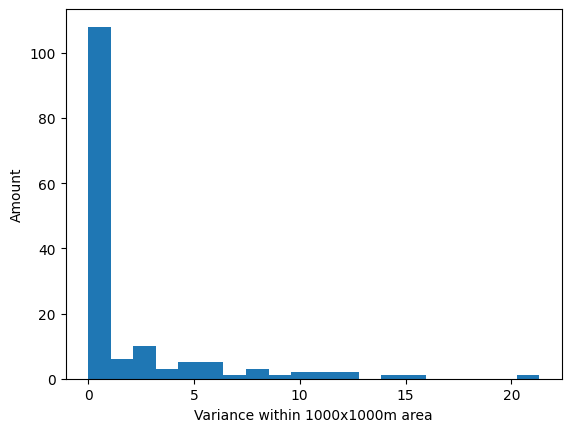

In [93]:
#histogram of different variances within 1000x1000m squares
plt.hist(squares['Variance'], bins=20)
plt.ylabel('Amount')
plt.xlabel('Variance within 1000x1000m area')
plt.show()

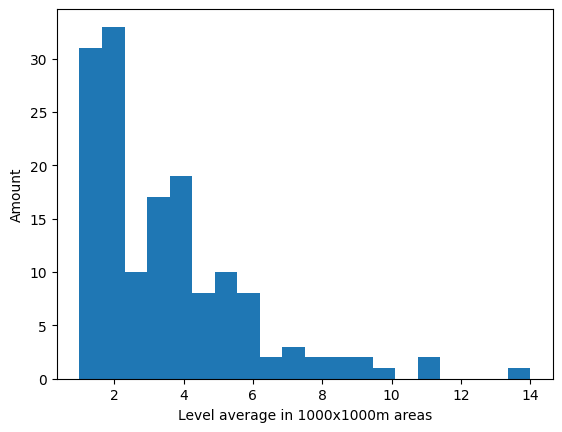

In [96]:
plt.hist(squares['Means'], bins=20)
plt.ylabel('Amount')
plt.xlabel('Level average in 1000x1000m areas')
plt.show()

In [90]:
#looping through 500x500 squares of the data and collecting variances and means of level-data
x = 650000
size = 500

count2 = []
means2 = []
variances2 = []

while x < 681000-size:
    y = 6566000
    while y < 6598000-size:
        temp = all.cx[x:x+size, y:y+size]
        if temp.shape[0] > 1:
            means2.append(temp['building:levels'].astype(float).mean())
            variances2.append(temp['building:levels'].astype(float).var())
            count2.append(temp.shape[0])
        y += size
        #print(x,y)
    x += size

In [91]:
squares2 = pd.DataFrame({'Count': count2, 'Means': means2, 'Variance': variances2})

#the variation in levels within 500x500meter squares
squares2['Variance'].mean()

1.584496486106649

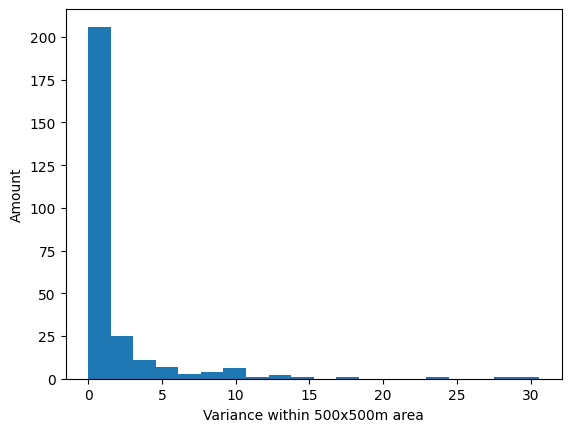

In [94]:
#histogram of different variances within 500x500m squares
plt.hist(squares2['Variance'], bins=20)
plt.ylabel('Amount')
plt.xlabel('Variance within 500x500m area')
plt.show()